# Adversarial sequential games

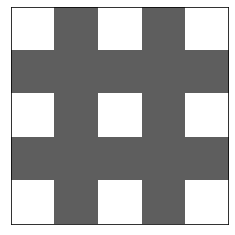

In [30]:
from copy import deepcopy
from enum import Enum
from typing import Any, NamedTuple, Tuple

import numpy as np
from numpy.typing import ArrayLike

# %matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

TIC_TAC_TOE = """
 | | 
-----
 | | 
-----
 | | 
"""

class State:
    def __init__(self, array: ArrayLike):
        self._array = array
        
    def __hash__(self):
        return hash(tuple(self._array.astype(int).flatten()))
        
    def __eq__(self, other):
        return np.all(np.equal(self._array, other._array))
    
    @property
    def array(self):
        return self._array
    
    def copy(self):
        return State(self._array.copy())
    
class Player(Enum):
    CrossPlayer = 1
    CirclePlayer = 2
    
class Action(NamedTuple):
    x: int
    y: int

class TicTacToe:
    def __init__(self, tic_tac_toe_str: str = TIC_TAC_TOE):
        tic_tac_toe = []
        for y, line in enumerate(tic_tac_toe_str.split("\n")):
            row = []
            for c in line:
                if c == " ":
                    row.append(0)  # spaces are 0s
                else:
                    row.append(0.7)  # walls are 1s
            tic_tac_toe.append(row)
        self._tic_tac_toe = np.array(tic_tac_toe[1:-1], dtype=np.float32)
        self._ax = None
        self._fig = None
        self._image = None
        
    def reset(self):
        return State(np.zeros(shape=[3, 3], dtype=np.int32))
    
    def get_next_state(self, state: State, action: Tuple[Player, Action]) -> Tuple[State, float, bool]:
        assert state.array[action[1].x][action[1].y] == 0
        next_state = state.copy()
        next_state.array[action[1].x][action[1].y] = action[0].value
        if (np.asarray(np.prod(next_state.array, axis=0) == action[0].value**3).sum() > 0 or
            np.asarray(np.prod(next_state.array, axis=1) == action[0].value**3).sum() > 0 or
            np.prod(np.diagonal(next_state.array)) == action[0].value**3 or
            np.prod(np.diagonal(np.fliplr(next_state.array))) == action[0].value**3):
            return next_state, -2 * action[0].value + 3, True
        else:
            return next_state, 0, False
    
    def render(self, state: State) -> Any:
        if self._ax is None:
            fig, ax = plt.subplots(1)
            fig.canvas.set_window_title("tic-tac-toe")
            ax.set_aspect("equal")  # set the x and y axes to the same scale
            plt.xticks([])  # remove the tick marks by setting to an empty list
            plt.yticks([])  # remove the tick marks by setting to an empty list
            ax.invert_yaxis()  # invert the y-axis so the first row of data is at the top
            self._ax = ax
            self._fig = fig
            plt.ion()
        if self._image is None:
            self._image = self._ax.imshow(self._tic_tac_toe, cmap='Greys', vmin=0, vmax=1)
        else:
            self._image.set_data(self._tic_tac_toe)
        for row in range(3):
            for col in range(3):
                if state.array[row][col] == 1:
                    self._ax.scatter(2 * col, 2 * row, s=500, c='blue', marker='x')
                elif state.array[row][col] == 2:
                    self._ax.scatter(2 * col, 2 * row, s=500, facecolors='none', edgecolors='red')
        display(self._fig)
        clear_output(wait = True)
        plt.pause(0.001)
        
tic_tac_toe = TicTacToe()
tic_tac_toe.render(tic_tac_toe.reset())

In [37]:

from __future__ import annotations
from typing import Dict
from typing import Any, Tuple, List

class Tree:
    class Node:
        def __init__(self,
                     data: Any,
                     max_player: bool = True,
                     terminal: bool = False,
                     terminal_value: float = 0,
                     best_child: Tree.Node = None):
            self._data = data
            self._max_player = max_player
            self._terminal = terminal
            self._terminal_value = terminal_value
            self._best_child = best_child
            self._children: List[Tuple[Tree.Node, str]] = []
            
        @property
        def data(self):
            return self._data
        
        @property
        def max_player(self):
            return self._max_player
        
        @property
        def terminal(self):
            return self._terminal
        
        @property
        def terminal_value(self):
            return self._terminal_value
        
        @property
        def best_child(self):
            return self._best_child
        
        def __eq__(self, other: Tree.Node):
            return self._data.__eq__(other._data)
        
        def __hash__(self):
            return hash(self._data)
        
        def __str__(self):
            return str(self._data)
        
        def __repr__(self):
            return 'Node(data: {}, max_player: {}, terminal: {}, best child: {})'.format(
                repr(self._data),
                'true' if self._max_player else 'false',
                'true' if self._terminal else 'false',
                repr(self._child._data) if self._child is not None else None)
            
    def __init__(self):
        self._nodes: Dict[Any, Tree.Node] = {}
        
    def get_children(self, node: Node) -> List[Tuple[Node, str]]:
        if node.data not in self._nodes or len(node.children) == 0:
            node.children = self.generate_children(node)
            assert all((c[0].max_player and not node.max_player) or
                       (not c[0].max_player and node.max_player)
                       for c in node.children)
            self._nodes[node.data] = node
        return self._nodes[node.data].children
    
    def generate_children(self, node: Node) -> List[Tuple[Node, str]]:
        raise NotImplementedError
    
    def is_terminal(self, node: Node) -> bool:
        raise node.is_terminal
    
    def render(self, node: Node) -> None:
        pass

In [33]:
from typing import Callable

def alphabeta(node : Tree.Node,
              tree: Tree,
              depth : int,
              alpha : float,
              beta : float,
              maximizing_player : bool,
              evaluate : Callable[[Tree.Node], float]):
    if depth == 0 and tree.is_terminal(node):
        return evaluate(node)
    if maximizing_player:
        value = -float('inf')
        for child in tree.get_children(node):
            tentative = alphabeta(child[0], depth - 1, alpha, beta, False)
            if tentative >= value:
                node.best_child = child[0]
                value = tentative
            if value >= beta:
                break
            alpha = max(alpha, value)
        return value
    else:
        value = float('inf')
        for child in tree.get_children(node):
            tentative = alphabeta(child[0], depth - 1, alpha, beta, True)
            if tentative <= value:
                node.best_child = child[0]
                tentative = value
            if value <= alpha:
                break
            beta = min(beta, value)
        return value

In [38]:
class TicTacToeTree(Tree):
    def __init__(self, tic_tac_toe):
        super().__init__()
        self._tic_tac_toe = tic_tac_toe
    
    def generate_children(self, node: Tree.Node) -> List[Tuple[Tree.Node, str]]:
        state = node.data
        avail_posx, avail_posy = np.asarray(state.array == 0).nonzero()
        for i in range(len(avail_posx)):
            next_state, value, terminal = self._tic_tac_toe.get_next_state(
                state,
                (Player.CrossPlayer if node.max_player else Player.CirclePlayer,
                 Action(x=avail_posx[i], y=avail_posy[i]))
            )
            yield (
                Tree.Node(data=next_state,
                          max_player = not node.max_player,
                          terminal = terminal,
                          terminal_value = value),
                '{} at ({}, {})'.format(
                    'cross' if not node.max_player else 'circle',
                    str(avail_posx[i]),
                    str(avail_posy[i])
                )
            )
    
    def render(self, node: Tree.Node) -> None:
        self._tic_tac_toe.render(node.data)

In [40]:
tic_tac_toe_tree = TicTacToeTree(tic_tac_toe)
alphabeta(node=Tree.Node(data=tic_tac_toe.reset()),
          tree = tic_tac_toe_tree,
          depth=1000,
          alpha=-float("inf"),
          beta=float("inf"),
          maximizing_player=True,
          evaluate = lambda n : n.terminal_value)
node = Tree.Node(data=tic_tac_toe.reset())
tic_tac_toe.render(node.data)
while not node.terminal:
    node = node.best_child
    tic_tac_toe.render(node.data)

AttributeError: 'NoneType' object has no attribute 'data'